In [226]:
import time
import numpy as np
from scipy.integrate import odeint


def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [227]:
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [228]:
#r = odeint(vectors2, r0, t, args=(I, J))
#r = ode(f, jac).set_integrator('zvode', method='bdf').set_initial_value(r0, 0)

In [229]:
#r.set_initial_value(r0, 0)#.set_f_params(2.0).set_jac_params(2.0)

In [230]:
import matplotlib.pyplot as plt

In [231]:
Gamma_ud=0.4
Gamma_du=0.2
Gamma_el=1.6


gammaplus=Gamma_du/2
gammaminus=Gamma_ud/2
gammaz=Gamma_el/8


Dissipation_factor=1


Gamma=np.array(Dissipation_factor*[gammaplus,gammaminus,gammaz])  #[gamma+,gamma-,gammaz]

rho_init0=np.array([[1/2,1/2],[1/2,1/2]])    #density matrix |+><+|


def trace(A):
    return np.trace(A)

def matmu(A,B):
    return np.matmul(A,B)

#rho_init1=np.array([[1,0],[0,0]])    #By default
#rho_init2=np.array([[1,0],[0,0]])    #By default




N=10




sigma_p= np.array([[0,1],[0,0]])
sigma_m= np.array([[0,0],[1,0]])
sigma_z= np.array([[1,0],[0,-1]])


##Initial values one operator

sp_init0=trace(matmu(rho_init0,sigma_p))
sz_init0=trace(matmu(rho_init0,sigma_z))
sm_init0=trace(matmu(rho_init0,sigma_m))

Genit=[sp_init0,sz_init0,sm_init0]


r0=[]
fact=int(N*(N-1)/2)

r0=[Genit[0]]*N+[Genit[1]]*N+[Genit[0]**2]*fact+[Genit[0]*Genit[2]]*fact+[Genit[0]*Genit[1]]*2*fact+[Genit[1]**2]*fact

#Random interaction matrix

A=np.random.rand(N,N)
A= np.triu(A)
np.fill_diagonal(A, 0)

In [232]:
#Homogeneous interaction matrix

#Jef=3

#A=np.ones((N,N))
#A= np.triu(A)
#np.fill_diagonal(A, 0)
#A=Jef*A/N

In [233]:
def del_list(N):
    
    s=[]
    count=0
    for j in range (0,N):
        s.append((count)%N)
        count=count+1
    
    s_fin=s*(N) 

    count=0
    while count<len(s_fin):
        del(s_fin[count])
        count=count+N
    
    sfin=np.array(s_fin)
    
    return sfin

def new_indexer(N):
    s=[]
    for j in range(N):
        s=s+[j]*(N-1)
    return np.array(s)

def up_triang(N):
    ar = np.array(np.zeros((N,N)))
    indices = np.triu_indices_from(ar)
    indexer=[]
    for j in range(len(indices[0])):
        if indices[0][j]!=indices[1][j]:
            indexer.append([indices[0][j],indices[1][j]])
    return np.array(indexer)+N    

In [234]:
# If you want to get the index of the upper triangular matrix just do this up_triang(N)-N 



In [235]:
def index_p(Arr,ind):
    return np.array([i for i, e in enumerate(Arr) if e == ind])+int(2*N+N*(N-1))   #return the indexes required for dpdt

In [236]:
def computeLM(N):
    i = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)),dtype = 'complex_')
    r0=[]
    extern=np.zeros(int(N*(5*N-1)/2))
    
    
    Indexer=del_list(N)
    new_index=new_indexer(N)
    
    
    for j in range (0,N):  #dpdt
        i[j][j]=-(Gamma[0]+Gamma[1]+4*Gamma[2])
        for w in index_p(del_list(N),j):
            i[j][w]=2*1j*(A[j][new_index[w-int(2*N+N*(N-1))]]+A[new_index[w-int(2*N+N*(N-1))]][j])   #   
        
    for j in range (N,2*N): #dzdt
        i[j][j]=-2*(Gamma[0]+Gamma[1])
        extern[j]=2*(Gamma[0]-Gamma[1])

    for j in range (2*N,int(2*N+N*(N-1)/2)):  #dpadpbdt
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    for j in range (int(2*N+N*(N-1)/2),int(2*N+N*(N-1))):  #dpadmbdt
        i[j][j]=-2*(Gamma[0]+Gamma[1]+4*Gamma[2])
    
    
    count=0
    for j in range (int(2*N+N*(N-1)),int(2*N+2*N*(N-1))):   #dzadpbdt
        i[j][j]=-(3*(Gamma[0]+Gamma[1])+4*Gamma[2])
        i[j][Indexer[count]]=2*(Gamma[0]-Gamma[1])+2*1j*(A[Indexer[count]][new_index[count]]+A[new_index[count]][Indexer[count]])   #I use Jef for now
        count=count+1
        
    
    count=0        
    for j in range (int(2*N+2*N*(N-1)),int(2*N+5*N*(N-1)/2)):   #dzadzbdt
        i[j][j]=-4*(Gamma[0]+Gamma[1]) 
        i[j][up_triang(N)[count][0]]=-2*(Gamma[1]-Gamma[0])
        i[j][up_triang(N)[count][1]]=-2*(Gamma[1]-Gamma[0])
        count=count+1
        
    return extern, i

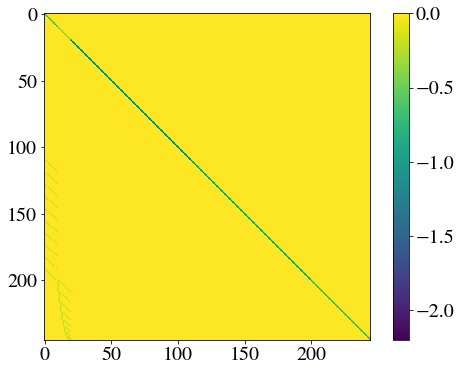

In [237]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.real(computeLM(N)[1]))
plt.colorbar()
plt.show()




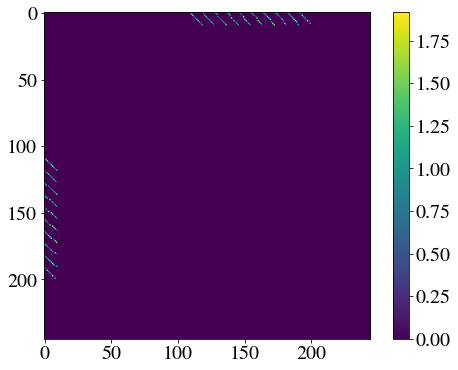

In [238]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(np.imag(computeLM(N)[1]))
plt.colorbar()
plt.show()


In [239]:
arr=del_list(N)
def index_zp(a,b,arr):
    return list(arr[a*(N-1):]).index(b)+a*(N-1)

In [240]:
def indexzz(a,b,arry):
    if a<b:
        return arry.tolist().index([a,b])+2*(N**2)
    elif a>b:
        return arry.tolist().index([b,a])+2*(N**2)

In [241]:
def vectors2(r, t, extern, i):
    s = i @ r  #Vector multiplication
    drdt = s+extern
    
    
    arr_in = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)),dtype = 'complex_')
    a_list = np.array(list(range( N)))
    triang_ind=up_triang(N)-N
    arr=del_list(N)
    
    
    count=0
    
    init_in=N**2+N
    
    init1_in=2*(N**2)
    
    for j1 in range (2*N,int(2*N+N*(N-1)/2)):  #dpadpbdt
        a0=triang_ind[count][0]
        a1=triang_ind[count][1]
        index_ab=index_zp( a0 ,a1,arr)
        abz_ind=index_ab+init1_in
        
        j1pm=j1+int(N*(N-1)/2)
        
        
        for ju in np.array(list(set(a_list) - set(triang_ind[count]))): 
            
            index_0=index_zp( ju ,a0,arr)
            index_1=index_zp( ju ,a1,arr)
            
            index_0per=index_zp( a0,ju,arr)
            index_1per=index_zp( a1 ,ju,arr)
            
            
            
            
            
            arr_in[j1][j1]=arr_in[j1][j1]+r[ju+N]*2j* (A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju])
            #print(j1,j1,".",ju+N,".","|",ju,a0,a0,ju,ju,a1,a1,ju)
            
            arr_in[j1][a0]=arr_in[j1][a0]+ 2j* (r[init_in+index_1] -2*r[a1]*r[ju+N])  *(A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju]  )
            #print(j1,a0,".",init_in+index_1,".andMinus2",a1,ju+N,"|",ju,a0,a0,ju,ju,a1,a1,ju)
            
            
            arr_in[j1][a1]=arr_in[j1][a1]+ 2j* r[init_in+index_0]  *(A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju])
            #print(j1,a1,".",init_in+index_0,"|",ju,a0,a0,ju,ju,a1,a1,ju)
        

            
            ab_ind=init_in+index_0
            
            
            
            
            arr_in[j1pm][j1pm]=arr_in[j1pm][j1pm]+r[ju+N]*(-2j)* (-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju])
            #print(j1pm,j1pm,".",ju+N,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            arr_in[j1pm][ab_ind]=arr_in[j1pm][ab_ind]+(-2j)*np.conjugate(r[a1])*(-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju])
            #print(j1pm,ab_ind,".conj",a1,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            arr_in[j1pm][a0]=arr_in[j1pm][a0]+  (-2j)*(np.conjugate(r[init_in+index_1])   - 2*np.conjugate(r[a1])*r[ju+N] ) *(-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju] )
            #print(j1pm,a0,".conj",init_in+index_1,"-","conj",a1,ju+N,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            
        count=count+1        
        
        
        goun=0
        
        
        for j in range(int(N**2-N),N**2):          
            
            a0=triang_ind[goun][0]
            a1=triang_ind[goun][1]
            index_ab=index_zp( a0 ,a1,arr)
            abz_ind=index_ab+init1_in
        
            j1pm=j1+int(N*(N-1)/2)
            
            z0ind=a0+N
            
            
            
            for ju in np.array(list(set(a_list) - set(triang_ind[goun]))):
                
                
                index_0=index_zp( ju ,a0,arr)
                index_1=index_zp( ju ,a1,arr)
            
                index_0per=index_zp( a0,ju,arr)
                index_1per=index_zp( a1 ,ju,arr)
                
                zpindex0=init_in+index_0
                
                
                
                
                arr_in[j][j]=arr_in[j][j]+r[ju]*2j* (A[ju][a1]+A[a1][ju])
                
                arr_in[j][z0ind]=arr_in[j][z0ind]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[zpindex0] -2* r[a1]*r[ju] )
                
                arr_in[j][a1]=arr_in[j][a1]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[indexzz(a0,ju,triang_ind)])
                
                
        
        goun=goun+1
        
        
    
    
    
    
    
    
    s1=  arr_in @ r       
    drdt=drdt+ s1   
    
    return drdt

In [ ]:
import time 

t0=time.time()
extern, i = computeLM(N)

t = np.linspace(0, 8, 5000)

r = odeintz(vectors2, r0, t, args=(extern, i))


t1=time.time()

print(t1-t0," "+str(N)," "+str((t1-t0)/(N*(5*N-1)/2)) )

In [ ]:
for j in range(int(N*(5*N-1)/2)):
    plt.plot(t,np.real(r[:,j]))
    plt.plot(t,np.imag(r[:,j]))


In [84]:
def tin(a):
            if a=="xx":
                return 0
            elif a=="xy":
                return 1
            elif a=="xz" :
                return 2
            elif a=="yx":
                return 3
            elif a=="yy":
                return 4
            elif a=="yz":
                return 5
            elif a=="zx":
                return 6
            elif a=="zy":
                return 7
            elif a=="zz":
                return 8

In [184]:
def vectors2(t,N):
    
    arr_in = np.zeros((int(N*(5*N-1)/2),int(N*(5*N-1)/2)))
    a_list = np.array(list(range( N)))
    triang_ind=up_triang(N)-N
    arr=del_list(N)
    
    
    count=0
    
    init_in=N**2+N
    
    init1_in=2*(N**2)
    
    for j1 in range (2*N,int(2*N+N*(N-1)/2)):  #dpadpbdt
        a0=triang_ind[count][0]
        a1=triang_ind[count][1]
        index_ab=index_zp( a0 ,a1,arr)
        abz_ind=index_ab+init1_in
        
        j1pm=j1+int(N*(N-1)/2)
        
        for ju in np.array(list(set(a_list) - set(triang_ind[count]))): 
            
            index_0=index_zp( ju ,a0,arr)
            index_1=index_zp( ju ,a1,arr)
            
            index_0per=index_zp( a0,ju,arr)
            index_1per=index_zp( a1 ,ju,arr)
            
            
            
            
            #arr_in[j1][j1]=arr_in[j1][j1]+r[ju]*2j* (A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju])
            print(j1,j1,".",ju+N,".","|",ju,a0,a0,ju,ju,a1,a1,ju)
            
            #arr_in[j1][a0]=arr_in[j1][a0]+ 2j* (r[init_in+index_0] -2*r[a1]*r[ju])  *(A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju]  )
            print(j1,a0,".",init_in+index_1,".andMinus2",a1,ju+N,"|",ju,a0,a0,ju,ju,a1,a1,ju)
            
            
            #arr_in[j1][a1]=arr_in[j1][a1]+ 2j* r[init_in+index_1]  *(A[ju][a0]+A[a0][ju]+A[ju][a1]+A[a1][ju])
            print(j1,a1,".",init_in+index_0,"|",ju,a0,a0,ju,ju,a1,a1,ju)
        

            
            ab_ind=init_in+index_0
            
            
            
            
            #arr_in[j1pm][j1pm]=arr_in[j1pm][j1pm]+r[ju]*(-2j)* (-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju])
            
            print(j1pm,j1pm,".",ju+N,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            #arr_in[j1pm][ab_ind]=arr_in[j1pm][ab_ind]+(-2j)*np.conjugate(r[a1])*(-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju])
            
            print(j1pm,ab_ind,".conj",a1,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            #arr_in[j1pm][a0]=arr_in[j1pm][a0]+  (-2j)*(np.conjugate(r[ab_ind])   - 2*np.conjugate(r[a1])*r[ju] ) *(-A[ju][a0]-A[a0][ju]+A[ju][a1]+A[a1][ju] )
            
            print(j1pm,a0,".conj",init_in+index_1,"-","conj",a1,ju+N,"|-",ju,a0,"-",a0,ju,ju,a1,a1,ju)
            
            
            
        count=count+1        
        
        
    goun=0
    
    print("here")
        
        
    for j in range(int(N**2-N),(N**2)):          
            
        a0=triang_ind[goun][0]
        a1=triang_ind[goun][1]
        index_ab=index_zp( a0 ,a1,arr)
        abz_ind=index_ab+init1_in
            
        z0ind=a0+N
            
            
            
        for ru in np.array(list(set(a_list) - set(triang_ind[goun]))):
                
                
            index_0=index_zp( ru ,a0,arr)
            index_1=index_zp( ru ,a1,arr)
            
            index_0per=index_zp( a0,ru,arr)
            index_1per=index_zp( a1 ,ru,arr)
                
            zpindex0=init_in+index_0
                
                
                
                
            #arr_in[j][j]=arr_in[j][j]+r[ju]*2j* (A[ju][a1]+A[a1][ju])
                
            print(index_ab+N**2+N,index_ab+N**2+N,ru+N,"|",ru,a1,a1,ru)
                
            #arr_in[j][z0ind]=arr_in[j][z0ind]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[zpindex0] -2* r[a1]*r[ju] )
                
            print(index_ab+N**2+N,z0ind,zpindex0,".andMinus2",a1,ru,"|",ru,a1,a1,ru)
            
                
            #arr_in[j][a1]=arr_in[j][a1]+ 2j* (A[ju][a1]+A[a1][ju]) * (  r[indexzz(a0,ju,triang_ind)])
                
            print(index_ab+N**2+N,a1,indexzz(a0,ru,triang_ind),ru,a1,a1,ru)
                
                
        
        goun=goun+1
        
        

    
    return 89

In [185]:
vectors2(8,3)

6 6 . 5 . | 2 0 0 2 2 1 1 2
6 0 . 17 .andMinus2 1 5 | 2 0 0 2 2 1 1 2
6 1 . 16 | 2 0 0 2 2 1 1 2
9 9 . 5 |- 2 0 - 0 2 2 1 1 2
9 16 .conj 1 |- 2 0 - 0 2 2 1 1 2
9 0 .conj 17 - conj 1 5 |- 2 0 - 0 2 2 1 1 2
7 7 . 4 . | 1 0 0 1 1 2 2 1
7 0 . 15 .andMinus2 2 4 | 1 0 0 1 1 2 2 1
7 2 . 14 | 1 0 0 1 1 2 2 1
10 10 . 4 |- 1 0 - 0 1 1 2 2 1
10 14 .conj 2 |- 1 0 - 0 1 1 2 2 1
10 0 .conj 15 - conj 2 4 |- 1 0 - 0 1 1 2 2 1
8 8 . 3 . | 0 1 1 0 0 2 2 0
8 1 . 13 .andMinus2 2 3 | 0 1 1 0 0 2 2 0
8 2 . 12 | 0 1 1 0 0 2 2 0
11 11 . 3 |- 0 1 - 1 0 0 2 2 0
11 12 .conj 2 |- 0 1 - 1 0 0 2 2 0
11 1 .conj 13 - conj 2 3 |- 0 1 - 1 0 0 2 2 0
here
12 12 5 | 2 1 1 2
12 3 16 .andMinus2 1 2 | 2 1 1 2
12 1 19 2 1 1 2
13 13 4 | 1 2 2 1
13 3 14 .andMinus2 2 1 | 1 2 2 1
13 2 18 1 2 2 1
15 15 3 | 0 2 2 0
15 4 12 .andMinus2 2 0 | 0 2 2 0
15 2 18 0 2 2 0


89

In [96]:
index_ab=index_zp( 1 ,0,arr)

index_ab

2

In [145]:
arr=del_list(N)
count=0
init_in=N**2+N
a0=triang_ind[count][0]
a1=triang_ind[count][1]
index_1per=index_zp( a0 ,2,arr)

index_zp(2,0,arr)+init1_in


19

In [109]:
index_zp(a,b,arr)

5

In [113]:
list(set(a_list) - set(triang_ind[0]))

[2]

In [126]:
triang_ind

array([[0, 1],
       [0, 2],
       [1, 2]], dtype=int64)

In [132]:
index_0per=index_zp(2,0,arr)
index_1per=index_zp( 1,2,arr)

In [134]:
index_0per

4

In [141]:
count=0
np.array(list(set(a_list) - set(triang_ind[count])))

array([2])

In [148]:
index_zp(2,0,arr)

4

In [175]:
triang_ind

array([[0, 1],
       [0, 2],
       [1, 2]], dtype=int64)

In [225]:
N=3
arr=del_list(N)
a=1
b=0

index_zp(a,b,arr)

2